# Google Colab: Access Webcam for Images and Video
This notebook will go through how to access and run code on images and video taken using your webcam.  

For this purpose of this tutorial we will be using OpenCV's Haar Cascade to do face detection on our Webcam image and video.

In [1]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

## Helper Functions
Below are a few helper function to make converting between different image data types and formats. 

In [2]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

## Haar Cascade Classifier
For this tutorial we will run a simple object detection algorithm called Haar Cascade on our images and video fetched from our webcam. OpenCV has a pre-trained Haar Cascade face detection model. 

In [3]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

## Webcam Images
Running code on images taken from webcam is fairly straight-forward. We will utilize code within Google Colab's **Code Snippets** that has a variety of useful code functions to perform various tasks.

We will be using the code snippet for **Camera Capture** to utilize your computer's webcam.

In [4]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


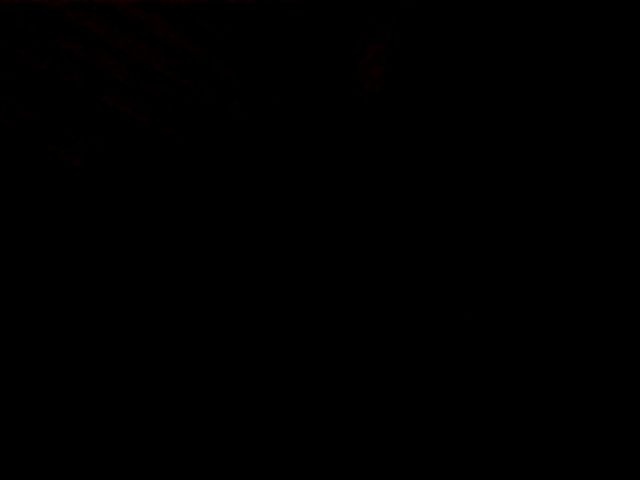

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

(480, 640)


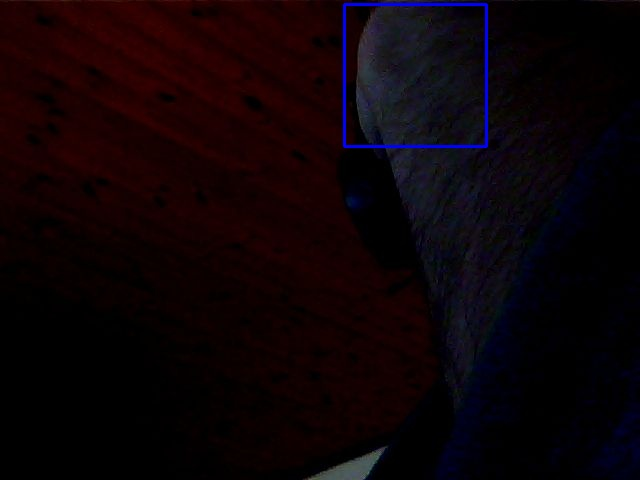

string indices must be integers


In [ ]:
try:
  while(True):
      filename = take_photo('photo.jpg')
      display(Image(filename))
      img = js_to_image(filename["img"])
      filename = bbox_to_bytes(img)
      display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## Webcam Videos
Running code on webcam video is a little more complex than images. We need to start a video stream using our webcam as input. Then we run each frame through our progam (face detection) and create an overlay image that contains bounding box of detection(s). We then overlay the bounding box image back onto the next frame of our video stream.

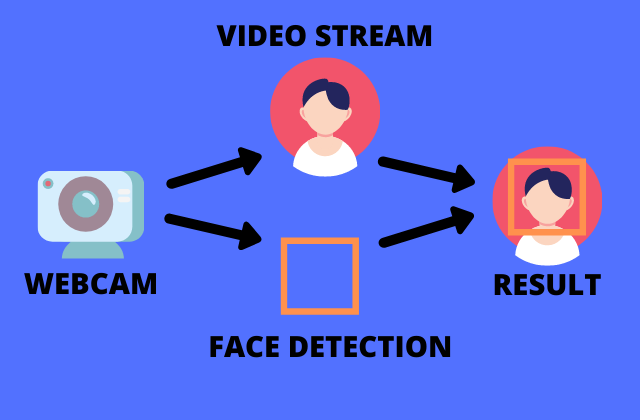</center>

In [5]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray)
    # get face bounding box for overlay
    for (x,y,w,h) in faces:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

Installa pacchetti aggiuntivi

In [7]:
!pip install face_recognition

     |████████████████████████████████| 100.1 MB 22 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566186 sha256=7f60cb0573c2afb3c512fc33d1454bbf9e57d6447cd3f4d637e0e06b6578afd0
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [ ]:
import face_recognition
import cv2 as cv
from PIL import Image
from scipy.spatial import distance as dist
from google.colab.patches import cv2_imshow
import time
import numpy as np

def main():
    framec = 0;
    label_html = 'Capturing...'
    # initialze bounding box to empty
    bbox = ''
    count = 0 
    path = "drive/leo.jpg"
    cattura = 1
    # "myvideo.mp4" "Doorbell2.mp4"  "occhiolino.mp4"   "Doorbell1.mp4""Doorbell1.mp4" "leo_wink_smile.mp4"
    imagel = face_recognition.load_image_file(path)
    imagea = face_recognition.load_image_file("files/ma.png")
    try:
        leo_face_encoding = face_recognition.face_encodings(imagel)[0]
        ma_face_encoding = face_recognition.face_encodings(imagea)[0]
    except Error:
        print("I didn't any faces, quitting...\n")
        time.sleep(0.02)
        print(".\n")
        time.sleep(0.02)
        print(".\n")
        time.sleep(0.02)
        print(".\n")

    known_face_encodings = [
        leo_face_encoding,
        ma_face_encoding
    ]
    
    known_face_names = [
        "leo",
        "maurizio"
    ]
    face_names = []
    apertura_sx = 0
    apertura_dx = 0
    toll1 = 2
    matches = [False]
    sorriso = False
    occhiolino = False
    name = "Unknown"
    cfs = 0
    cfo = 0
    t0 = time.time()
    video_stream()
    while True:
        js_reply = video_frame(label_html, bbox)
        if not js_reply:
            break
        frame = js_to_image(js_reply["img"])
        res_frame = cv.resize(frame, (0, 0), fx=0.5, fy=0.5)
        face_locations = face_recognition.face_locations(res_frame)    
        if framec % 20 == 0:
            face_encodings = face_recognition.face_encodings(res_frame, face_locations)
            for face_encoding in face_encodings:
                matches = face_recognition.compare_faces(known_face_encodings, face_encoding)
                name = "Unknown"
                face_distances = face_recognition.face_distance(known_face_encodings, face_encoding)
                best_match_index = np.argmin(face_distances)
                if matches[best_match_index]:
                    name = known_face_names[best_match_index]
                face_names.append(name)
                if True in matches:
                    first_match_index = matches.index(True)
                    name = known_face_names[first_match_index]
                
        if framec % 3 == 0:
            face_landmarks_list = face_recognition.face_landmarks(res_frame) 
            for face_landmark in face_landmarks_list:
                occhiosx = face_landmark["left_eye"]
                occhiodx = face_landmark["right_eye"]
                apertura_sx = get_ear(occhiosx)
                apertura_dx = get_ear(occhiodx)
                occhiolino = ((not (apertura_sx < 0.25) and (apertura_dx < 0.25)) or
                    (not (apertura_dx < 0.25) and (apertura_sx < 0.25)) and True in matches)
                toplip = face_landmark["top_lip"]
                bottomlip = face_landmark["bottom_lip"]
                smiletl = get_smile_tl(toplip)
                smileop = get_smile_op(toplip, bottomlip)
                sorriso = smiletl or smileop
                print(f"\nsblocco{True in matches}\nocchiolino {occhiolino} {apertura_sx} {apertura_dx} \nsorriso {sorriso} {smileop} {smiletl} \ntempo: {time.time()-t0}")
        framec += 1
        font = cv.FONT_HERSHEY_SIMPLEX
        for (top, right, bottom, left) in face_locations:
            cv.rectangle(res_frame, (left, top), (right, bottom), (0, 0, 255), 2)
            # Draw a label with a name below the face
            cv.rectangle(res_frame, (left, bottom - 35), (right, bottom), (0, 0, 255), cv.FILLED)
            cv.putText(res_frame, name, (left + 6, bottom - 6), font, 1.0, (255, 255, 255), 1)
        cv.putText(res_frame, f'f{matches} w{occhiolino} s{sorriso}', (10,10), font, 0.2, (0, 0, 0), 1, cv.LINE_AA)
        res_frame = cv.resize(res_frame, (600, 800))
        clear_output(wait=True)
        cv2_imshow(res_frame)
        if cv.waitKey(1) & 0xFF == ord('q') : # or (True in matches and occhiolino and sorriso):
            break

    # Destroy all the windows
    time.sleep(0.2)
    print(".\n")
    time.sleep(0.2)
    print(".\n")
    time.sleep(0.2)
    print(".\n")
    cap.release()
    cv.destroyAllWindows()
    print(apertura_dx)
    print(apertura_sx)
    print(occhiolino)
    print(toll1)
    t1 = time.time()
    total = t1-t0
    print(f"fps: {framec/total}")
    
def get_ear(eye):
    A = dist.euclidean(eye[1], eye[5])
    B = dist.euclidean(eye[2], eye[4])
    C = dist.euclidean(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

def get_smile_tl(top_lip):
    return top_lip[0][1]<top_lip[4][1] or top_lip[6][1]<top_lip[2][1]

def get_smile_op(top_lip, bottom_lip):
    sar = dist.euclidean(top_lip[0],top_lip[6])/dist.euclidean(bottom_lip[9],top_lip[9])
    return sar < 5 and sar > 3

if __name__ == "__main__":
    main()

FileNotFoundError: ignored

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


errore
wink at:           0.537285566329956 ap sx0.25335270359176765 ap dx0.17647058823529413
smile at:          0.5373334884643555
test concluded in: 0.5373334884643555
image dimensions:  (256, 171, 3)


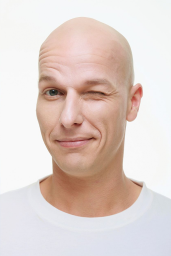

In [14]:
# test velocità riconoscimento facciale e features
import face_recognition
import cv2 as cv
from google.colab.patches import cv2_imshow
from PIL import Image
import time
from scipy.spatial import distance as dist

def main():

    imagel = face_recognition.load_image_file("/content/drive/My Drive/leo.jpg")
    imageb = face_recognition.load_image_file("/content/drive/My Drive/biden.jpeg")
    imagea = face_recognition.load_image_file("/content/drive/My Drive/ma.png")
    try:
        leo_face_encoding = face_recognition.face_encodings(imagel)[0]
        bi_face_encoding = face_recognition.face_encodings(imageb)[0]
        ma_face_encoding = face_recognition.face_encodings(imagea)[0]
    except Error:
        print("I didn't any faces, quitting...\n")
        time.sleep(0.02)
        print(".\n")
        time.sleep(0.02)
        print(".\n")
        time.sleep(0.02)
        print(".\n")

    known_face_encodings = [
        leo_face_encoding,
        bi_face_encoding,
        ma_face_encoding
    ]
    occhiolino = False
    sorriso = False
    sblocco = [False]
    t_start = 0
    t_sblocco = 0
    t_occhiolino = 0
    t_sorriso = 0
    img = cv.imread('photos/maur_wink_smile.png', cv.IMREAD_UNCHANGED)
    toll1 = 19 # euristico
    uno = img

    t_start = time.time()
    image = cv.imread("/content/drive/My Drive/wink2.png")
    image = cv.resize(image, (0, 0), fx=0.5, fy=0.5)
    new_encoding = face_recognition.face_encodings(image)[0]
    sblocco = face_recognition.compare_faces(known_face_encodings, new_encoding)
    if True in sblocco: t_sblocco = time.time()
    face_landmarks_list = face_recognition.face_landmarks(image)
    for face_landmark in face_landmarks_list:
        occhiosx = face_landmark["left_eye"]
        occhiodx = face_landmark["right_eye"]
        apertura_sx = get_ear(occhiosx)
        apertura_dx = get_ear(occhiodx)
        occhiolino = (not (apertura_sx < 0.23) and (apertura_dx < 0.23)) or (not (apertura_dx < 0.23) and (apertura_sx < 0.23))
        if occhiolino: t_occhiolino = time.time()
        toplip = face_landmark["top_lip"]
        bottomlip = face_landmark["bottom_lip"]
        smiletl = get_smile_tl(toplip)
        smileop = get_smile_op(toplip, bottomlip)
        sorriso = smiletl or smileop
        if sorriso: t_sorriso = time.time()
        t_end = time.time()
    
    if True in sblocco: print(f"unlocked at:       {t_sblocco - t_start}") 
    else: print("errore")
    if occhiolino: print(f"wink at:           {t_occhiolino - t_start} ap sx{apertura_sx} ap dx{apertura_dx}") 
    else: print(f"errore ap sx{apertura_sx} ap dx{apertura_dx}") 
    if sorriso: print(f"smile at:          {t_sorriso - t_start}") 
    else: print("errore")
    print(f"test concluded in: {t_end - t_start}")
    print(f"image dimensions:  {image.shape}")
    cv2_imshow(image)
    cv.waitKey(0)
    cv.destroyAllWindows() 

def get_ear(eye):
    A = dist.euclidean(eye[1], eye[5])
    B = dist.euclidean(eye[2], eye[4])
    C = dist.euclidean(eye[0], eye[3])
    # compute the eye aspect ratio
    ear = (A + B) / (2.0 * C)
    # return the eye aspect ratio
    return ear

    
def get_smile_tl(top_lip):
    return top_lip[0][1]<top_lip[4][1] or top_lip[6][1]<top_lip[2][1] or top_lip[0][1]<top_lip[6][1] or top_lip[6][1]<top_lip[0][1]

def get_smile_op(top_lip, bottom_lip):
    sar = dist.euclidean(top_lip[0],top_lip[6])/dist.euclidean(bottom_lip[9],top_lip[9])
    return sar < 5.5 and sar > 3

if __name__ == "__main__":
    main()
    